# AI algorithms : HW2

## Alexandre Francony

### Exercise 1
I chose to split the whole work into distinct steps for my code to be more readable and easier to understand.<br>
Step 0: import the necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

Step 1: Data Input, load item data (weights and values) from 'items.csv'.

In [109]:
items = pd.read_csv('items.csv', sep=';')
print(items.head())

   value  weight
0    140      11
1    142      38
2     60      22
3    107      37
4    131      28


Step 2: Genetic Algorithm Initialization, Initialize the parameters for the GA, including the population size, mutation rate, and number of generations.<br>
We set GA parameters that will influence the evolution process. The data from the CSV is converted into numpy arrays for easier manipulation.

In [ ]:
# GA parameters
population_size = 200
mutation_rate = 0.2 
generations = 100
elite_size = 10

# Extract weights and values from the dataset
weights = items['weight'].to_numpy()
values = items['value'].to_numpy()

# Maximum weight capacity of the knapsack
max_weight_capacity = 10000  

Step 3: define the initial population, which will be an array of potential solutions.<br>
Each individual in the population is represented as a binary array indicating which items are included in the knapsack. '1' means the item is included, while '0' means it is not.

In [ ]:
def initialize_population(population_size, num_items):
    population = []
    for _ in range(population_size):
        individual = np.random.randint(2, size=num_items)
        while np.sum(individual * weights) > max_weight_capacity:
            individual[np.random.choice(np.where(individual == 1)[0])] = 0
        population.append(individual)
    return np.array(population)

population = initialize_population(population_size, len(items))

Step 4: Fitness Function Definition which evaluates the total value of items selected without exceeding the weight capacity.<br>
The fitness function calculates the total value of items selected, but returns 0 if the total weight exceeds the allowed capacity. This encourages solutions within the weight limit.

In [ ]:
def fitness(individual, weights, values, max_weight_capacity):
    total_weight = np.sum(individual * weights)
    total_value = np.sum(individual * values)

    if total_weight > max_weight_capacity:
        penalty = (total_weight - max_weight_capacity) * 0.1  # Penalty proportional to excess weight
        return max(0, total_value - penalty)
    else:
        return total_value


Step 5: Implement Selection, Crossover, and Mutation<br>
- Selection uses a mix of elitism and roulette-wheel selection.
- Crossover uses a two-point crossover strategy to combine two parents.
- Mutation applies a random flip to each bit in an individual based on the mutation rate.


In [113]:
def selection(population, fitnesses, elite_size):
    # Select the top 'elite_size' individuals automatically
    selected_indices = np.argsort(fitnesses)[-elite_size:]
    selected_population = population[selected_indices]

    # Fill the rest with a probabilistic selection based on fitness
    total_fitness = np.sum(fitnesses)

    # Handle case where all fitness values are zero
    if total_fitness == 0:
        # If all fitnesses are zero, select randomly
        probabilities = np.ones(len(population)) / len(population)
    else:
        # Normal case: calculate probabilities proportional to fitness
        probabilities = fitnesses / total_fitness

    chosen_indices = np.random.choice(len(population), size=(population_size - elite_size), p=probabilities)
    selected_population = np.vstack((selected_population, population[chosen_indices]))

    return selected_population


def crossover(parent1, parent2):
    # Two-point crossover
    point1, point2 = sorted(np.random.choice(len(parent1), 2, replace=False))
    offspring = np.concatenate((parent1[:point1], parent2[point1:point2], parent1[point2:]))
    return offspring

def mutate(individual, mutation_rate):
    for i in range(len(individual)):
        if np.random.rand() < mutation_rate:
            # Flip the gene
            individual[i] = 1 - individual[i]

            # Ensure new individual still respects weight constraint
            if np.sum(individual * weights) > max_weight_capacity:
                individual[i] = 1  # Revert if adding this gene exceeds capacity
    return individual

def adaptive_mutation_rate(fitness_history):
    if len(fitness_history) > 10 and fitness_history[-10] == fitness_history[-1]:
        # If no improvement in the last 10 generations, increase mutation rate
        return min(1.0, mutation_rate * 1.5)
    return mutation_rate


Step 6: Run the GA for a fixed number of generations.

In [114]:
fitness_history = []

# for generation in range(generations):
#     # Calculate fitness for the population
#     fitnesses = np.array([fitness(ind, weights, values, max_weight_capacity) for ind in population])

#     # Selection
#     population = selection(population, fitnesses, elite_size)

#     # Crossover
#     new_population = []
#     for i in range(0, population_size, 2):
#         parent1, parent2 = population[i], population[i + 1]
#         offspring1, offspring2 = crossover(parent1, parent2), crossover(parent2, parent1)
#         new_population.append(offspring1)
#         new_population.append(offspring2)

#     # Update mutation rate adaptively
#     mutation_rate = adaptive_mutation_rate(fitness_history)

#     # Mutation
#     population = np.array([mutate(ind, mutation_rate) for ind in new_population])

#     # Track the best solution
#     best_fitness = np.max(fitnesses)
#     fitness_history.append(best_fitness)
#     fitness_history.append(best_fitness)
#     print(f"Generation {generation+1}: Best Fitness = {best_fitness}")


Step 7: Output the best solution and plot the evolution of fitness over generations.<br>


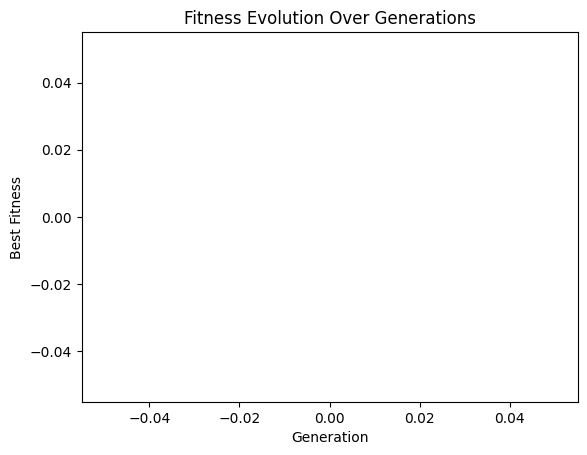

In [115]:
plt.plot(fitness_history)
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Fitness Evolution Over Generations')
plt.show()

### Exercise 2

Step 1: We define the input in a readable format. This includes the row and column constraints, fleet constraints (number of each ship type), and the initial grid layout.

In [116]:
# Sample input format, replace with actual input later
row_constraints = [2, 2, 1, 2, 1, 2]
column_constraints = [4, 0, 1, 3, 1, 1]
fleet_constraints = {
    "submarine": 3,
    "destroyer": 2,
    "cruiser": 1,
    "battleship": 0
}

# Initial grid layout (0 represents no hints)
initial_grid = [
    ['0', '0', 'M', '0', '0', '0'],
    ['0', '0', '0', '0', '0', '0'],
    ['0', '0', '0', '0', '0', '0'],
    ['0', '0', '0', '0', '0', '0'],
    ['0', '0', '0', '0', '0', '0'],
    ['0', '0', '0', '0', '0', '0'],
]
initial_grid = np.array(initial_grid)


Step 2: Formulate the problem as a CSP with variables and domains. Each grid cell is a variable with possible values representing water or a part of a ship.

In [117]:
# Variables: each cell in the grid (i, j)
grid_size = 6
variables = [(i, j) for i in range(grid_size) for j in range(grid_size)]

# Domain: possible values for each cell
domain = {
    '0': "Empty water",
    'S': "Submarine",
    'M': "Middle of a ship",
    '<': "Left end of a horizontal ship",
    '>': "Right end of a horizontal ship",
    '^': "Top end of a vertical ship",
    'v': "Bottom end of a vertical ship",
}
cell_domains = {var: list(domain.keys()) for var in variables}

# Set up the domains based on the initial grid (reduce domains where a specific value is given)
for i in range(grid_size):
    for j in range(grid_size):
        if initial_grid[i, j] != '0':  # Cell has a given value
            cell_domains[(i, j)] = [initial_grid[i, j]]


Step 3: Add constraints to enforce the fleet, row/column requirements, and the placement rules for ships.

In [118]:
# Constraint: row and column sums
def row_column_constraints(assignment, row_constraints, column_constraints):
    for i in range(grid_size):
        for j in range(grid_size):
            if initial_grid[i, j] != '0':
                cell_domains[(i, j)] = [initial_grid[i, j]]
            else:
                cell_domains[(i, j)] = list(domain.keys()) 


    return True

# Constraint: no touching ships
def no_touching_ships(assignment):
    for (i, j), value in assignment.items():
        if value != '0' and value != '.':
            neighbors = [
                (i-1, j-1), (i-1, j), (i-1, j+1),
                (i, j-1), (i, j+1),
                (i+1, j-1), (i+1, j), (i+1, j+1)
            ]
            for ni, nj in neighbors:
                if 0 <= ni < grid_size and 0 <= nj < grid_size:
                    if assignment.get((ni, nj), '0') not in ['0', '.']:
                        return False
    return True

# Constraint: fleet count
def fleet_constraints_satisfied(assignment, fleet_constraints):
    counts = defaultdict(int)
    for value in assignment.values():
        if value in ['S', '<', '>', '^', 'v', 'M']:
            counts[value] += 1
    # Check against fleet constraints
    for ship, count in fleet_constraints.items():
        if ship == "submarine" and counts['S'] != count:
            return False
        elif ship == "destroyer" and counts['M'] // 2 != count:
            return False
        elif ship == "cruiser" and counts['M'] // 3 != count:
            return False
        elif ship == "battleship" and counts['M'] // 4 != count:
            return False
    return True

def select_unassigned_variable(assignment, cell_domains):
    # Choose the variable with the fewest remaining values
    unassigned_variables = [v for v in variables if v not in assignment]
    return min(unassigned_variables, key=lambda var: len(cell_domains[var]))


Step 4: Implement a backtracking solver that attempts to solve the puzzle using these constraints.

In [123]:
def backtracking_search(assignment):
    # Check if assignment is complete
    if len(assignment) == len(variables):
        return assignment

    # Select an unassigned variable
    var = select_unassigned_variable(assignment, cell_domains)

    # Iterate over domain values
    for value in cell_domains[var]:
        # Create a new assignment
        local_assignment = assignment.copy()
        local_assignment[var] = value

        # Check constraints
        if (row_column_constraints(local_assignment, row_constraints, column_constraints) and
            no_touching_ships(local_assignment) and
            fleet_constraints_satisfied(local_assignment, fleet_constraints)):
            
            result = backtracking_search(local_assignment)
            if result is not None:
                return result

    return None

# Start with an empty assignment
initial_assignment = {}
solution = backtracking_search(initial_assignment)
if solution:
    print("Solution found:")
    for i in range(grid_size):
        print(''.join(solution.get((i, j), '.') for j in range(grid_size)))
else:
    print("No solution found.")


No solution found.
